#### CNN Model, AUC-ROC, Precision-Recall curve

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.preprocessing import label_binarize
import time

# Check device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define Data Augmentation & Normalization
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
data_dir = r"C:\Users\HP\Desktop\M.Tech-Prj\Chilli_leaf_Dataset"
train_dataset = datasets.ImageFolder(root=data_dir + "/Train", transform=train_transforms)
val_dataset = datasets.ImageFolder(root=data_dir + "/Validation", transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=data_dir + "/Test", transform=val_test_transforms)

# Create data loaders
batch_size = 32
dataloaders = {
    'Train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'Validation': DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    'Test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
}

dataset_sizes = {'Train': len(train_dataset), 'Validation': len(val_dataset), 'Test': len(test_dataset)}
class_names = train_dataset.classes

# Define a Simple CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize Model
model = CNNModel(num_classes=3).to(device)

# Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early Stopping Parameters
patience = 5
best_loss = float('inf')
counter = 0

# Training Parameters
num_epochs = 50
train_times = []

# Training Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    start_time = time.time()
    
    for phase in ['Train', 'Validation']:
        if phase == 'Train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'Train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'Train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    # Early Stopping Check
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        print(f"Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered! Loading best model.")
            model.load_state_dict(torch.load("best_model.pth"))
            break
    
    train_times.append(time.time() - start_time)
    print('-' * 50)

print("Training complete!")

# Evaluate on Test Set
model.eval()
all_test_labels = []
all_test_probs = []

with torch.no_grad():
    for inputs, labels in dataloaders['Test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # Convert to probabilities
        _, preds = torch.max(outputs, 1)
        
        all_test_labels.extend(labels.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

all_test_probs = np.array(all_test_probs)
all_test_labels = np.array(all_test_labels)

# Compute Metrics
accuracy = accuracy_score(all_test_labels, np.argmax(all_test_probs, axis=1))
conf_matrix = confusion_matrix(all_test_labels, np.argmax(all_test_probs, axis=1))
class_report = classification_report(all_test_labels, np.argmax(all_test_probs, axis=1), target_names=class_names)
print("\nFinal Test Accuracy: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Compute Specificity
specificity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
print("\nSpecificity per class:")
for label, spec in zip(class_names, specificity):
    print(f"{label}: {spec:.4f}")

# Precision-Recall Curve
n_classes = len(class_names)
y_true_bin = label_binarize(all_test_labels, classes=np.arange(n_classes))

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], all_test_probs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], all_test_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {class_names[i]} (AP={avg_precision:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

# AU-ROC Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_names[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Using device: cpu
Epoch 1/50
Train Loss: 1.0611 Acc: 0.4534
Validation Loss: 0.9744 Acc: 0.6129
--------------------------------------------------
Epoch 2/50
Train Loss: 0.8012 Acc: 0.6579
Validation Loss: 0.7240 Acc: 0.6290
--------------------------------------------------
Epoch 3/50
Train Loss: 0.6260 Acc: 0.7227
Validation Loss: 0.6768 Acc: 0.6452
--------------------------------------------------
Epoch 4/50
Train Loss: 0.4843 Acc: 0.7672
Validation Loss: 0.5576 Acc: 0.6935
--------------------------------------------------
Epoch 5/50
Train Loss: 0.4766 Acc: 0.7652
Validation Loss: 0.5510 Acc: 0.6452
--------------------------------------------------
Epoch 6/50
Train Loss: 0.4343 Acc: 0.8036
Validation Loss: 0.5422 Acc: 0.6452
--------------------------------------------------
Epoch 7/50
Train Loss: 0.4229 Acc: 0.8117
Validation Loss: 0.5850 Acc: 0.7097
Early stopping counter: 1/5
--------------------------------------------------
Epoch 8/50
Train Loss: 0.4324 Acc: 0.8138
Validatio

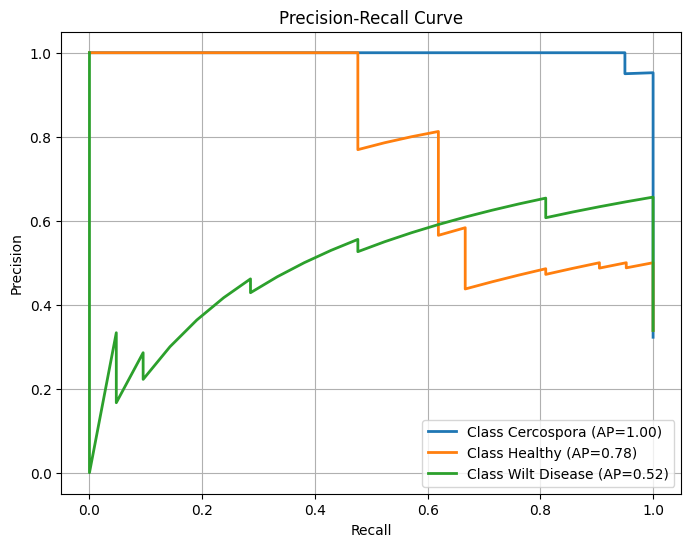

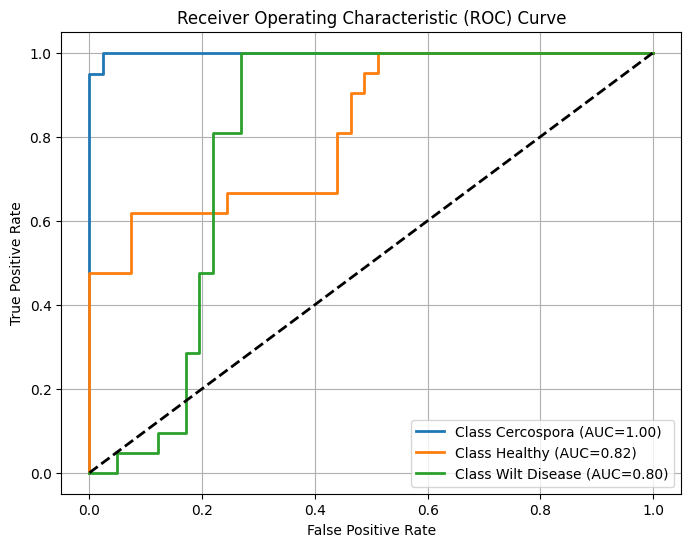

In [ ]:
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

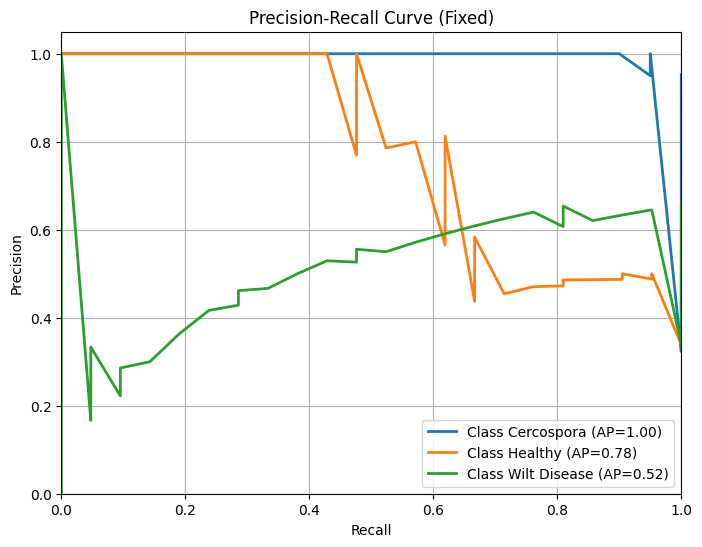

In [2]:
# Precision-Recall Curve (Fixed Version)
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], all_test_probs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], all_test_probs[:, i])

    # Fix: Ensure recall increases from 0 to 1 by reversing the order if needed
    recall, precision = zip(*sorted(zip(recall, precision)))

    plt.plot(recall, precision, lw=2, label=f'Class {class_names[i]} (AP={avg_precision:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0.0, 1.0])  # Ensuring recall goes from 0 to 1
plt.ylim([0.0, 1.05])  # Precision should be between 0 and 1
plt.title("Precision-Recall Curve (Fixed)")
plt.legend(loc="best")
plt.grid()
plt.show()


In [6]:
# Precision-Recall Curve
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], all_test_probs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], all_test_probs[:, i])
    print('precision=',precision,'recall=', recall)

precision= [0.32258065 0.32786885 0.33333333 0.33898305 0.34482759 0.35087719
 0.35714286 0.36363636 0.37037037 0.37735849 0.38461538 0.39215686
 0.4        0.40816327 0.41666667 0.42553191 0.43478261 0.44444444
 0.45454545 0.46511628 0.47619048 0.48780488 0.5        0.51282051
 0.52631579 0.54054054 0.55555556 0.57142857 0.58823529 0.60606061
 0.625      0.64516129 0.66666667 0.68965517 0.71428571 0.74074074
 0.76923077 0.8        0.83333333 0.86956522 0.90909091 0.95238095
 0.95       1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ] recall= [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 0.95 0.95 0.9  0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35
 0.3  0.25 0.2  0.15 0

In [7]:
# AU-ROC Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    print('fpr=',fpr,'tpr=',tpr,'roc_auc=',roc_auc)

fpr= [0.         0.         0.         0.02380952 0.02380952 1.        ] tpr= [0.   0.05 0.95 0.95 1.   1.  ] roc_auc= 0.9988095238095238
fpr= [0.         0.         0.         0.07317073 0.07317073 0.24390244
 0.24390244 0.43902439 0.43902439 0.46341463 0.46341463 0.48780488
 0.48780488 0.51219512 0.51219512 1.        ] tpr= [0.         0.04761905 0.47619048 0.47619048 0.61904762 0.61904762
 0.66666667 0.66666667 0.80952381 0.80952381 0.9047619  0.9047619
 0.95238095 0.95238095 1.         1.        ] roc_auc= 0.8234610917537747
fpr= [0.         0.02439024 0.04878049 0.04878049 0.12195122 0.12195122
 0.17073171 0.17073171 0.19512195 0.19512195 0.2195122  0.2195122
 0.26829268 0.26829268 1.        ] tpr= [0.         0.         0.         0.04761905 0.04761905 0.0952381
 0.0952381  0.28571429 0.28571429 0.47619048 0.47619048 0.80952381
 0.80952381 1.         1.        ] roc_auc= 0.7979094076655052


<Figure size 800x600 with 0 Axes>

#### CNN Model Training COmputation time

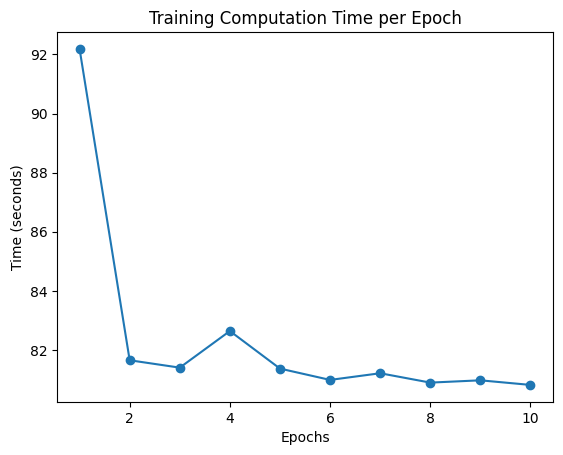

In [8]:
# Training Computation Time Curve
plt.plot(range(1, len(train_times) + 1), train_times, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Time (seconds)")
plt.title("Training Computation Time per Epoch")
plt.show()


#### EfficientNetB0 Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve, roc_curve, auc
import time

# Check device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define Data Augmentation & Normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet requires 224x224 images
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
data_dir = r"C:\Users\HP\Desktop\M.Tech-Prj\Chilli_leaf_Dataset"
train_dataset = datasets.ImageFolder(root=data_dir + "/Train", transform=train_transforms)
val_dataset = datasets.ImageFolder(root=data_dir + "/Validation", transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=data_dir + "/Test", transform=val_test_transforms)

# Create data loaders
batch_size = 32
dataloaders = {
    'Train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'Validation': DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    'Test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
}

dataset_sizes = {'Train': len(train_dataset), 'Validation': len(val_dataset), 'Test': len(test_dataset)}
class_names = train_dataset.classes

# Load EfficientNetB0 model (pretrained)
efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
num_features = efficientnet.classifier[1].in_features
efficientnet.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(class_names))  # Number of output classes
)

model = efficientnet.to(device)

# Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early Stopping Parameters
early_stopping_patience = 5
best_val_loss = float("inf")
epochs_no_improve = 0

# Training Parameters
num_epochs = 50
train_times = []

# Training Loop with Early Stopping
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    start_time = time.time()
    
    for phase in ['Train', 'Validation']:
        if phase == 'Train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        all_labels = []
        all_preds = []

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'Train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'Train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Check for Early Stopping in Validation Phase
        if phase == 'Validation':
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                epochs_no_improve = 0  # Reset counter
                torch.save(model.state_dict(), "best_model.pth")  # Save best model
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    print(f"Early stopping triggered! Stopping training at epoch {epoch+1}.")
                    model.load_state_dict(torch.load("best_model.pth"))  # Load best model
                    break
    
    train_times.append(time.time() - start_time)
    print('-' * 50)

    if epochs_no_improve >= early_stopping_patience:
        break

print("Training complete!")

# Evaluate on Test Set
model.load_state_dict(torch.load("best_model.pth"))  # Ensure best model is loaded
model.eval()

all_test_labels = []
all_test_preds = []
all_test_probs = []  # Store probabilities for PR and ROC curves

with torch.no_grad():
    for inputs, labels in dataloaders['Test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(preds.cpu().numpy())
        all_test_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Softmax for probability

# Compute Metrics
accuracy = accuracy_score(all_test_labels, all_test_preds)
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
class_report = classification_report(all_test_labels, all_test_preds, target_names=class_names)
print("\nFinal Test Accuracy: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Compute Specificity
specificity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
print("\nSpecificity per class:")
for label, spec in zip(class_names, specificity):
    print(f"{label}: {spec:.4f}")

# Precision-Recall Curve (for each class)
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(np.array(all_test_labels) == i, np.array(all_test_probs)[:, i])
    plt.plot(recall, precision, label=f'Class {class_names[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# AU-ROC Curve (for each class)
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(np.array(all_test_labels) == i, np.array(all_test_probs)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Training Computation Time Curve
plt.plot(range(1, len(train_times) + 1), train_times, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Time (seconds)")
plt.title("Training Computation Time per Epoch")
plt.show()

Using device: cpu
Epoch 1/50
Train Loss: 0.6103 Acc: 0.7308
Validation Loss: 3.0172 Acc: 0.4355
--------------------------------------------------
Epoch 2/50
Train Loss: 0.3291 Acc: 0.8623
Validation Loss: 0.2199 Acc: 0.9032
--------------------------------------------------
Epoch 3/50
Train Loss: 0.2432 Acc: 0.9291
Validation Loss: 0.4543 Acc: 0.8387
--------------------------------------------------
Epoch 4/50
Train Loss: 0.2193 Acc: 0.9170
Validation Loss: 0.4606 Acc: 0.8387
--------------------------------------------------
Epoch 5/50
Train Loss: 0.2260 Acc: 0.9372
Validation Loss: 0.5054 Acc: 0.8065
--------------------------------------------------
Epoch 6/50
Train Loss: 0.1496 Acc: 0.9453
Validation Loss: 0.3239 Acc: 0.8871
--------------------------------------------------
Epoch 7/50
Train Loss: 0.1032 Acc: 0.9615
Validation Loss: 0.3188 Acc: 0.8710
Early stopping triggered! Stopping training at epoch 7.
--------------------------------------------------
Training complete!

Fin

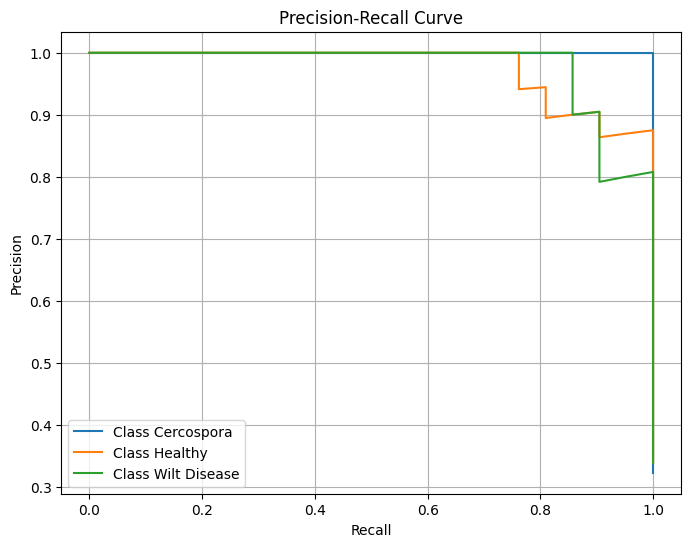

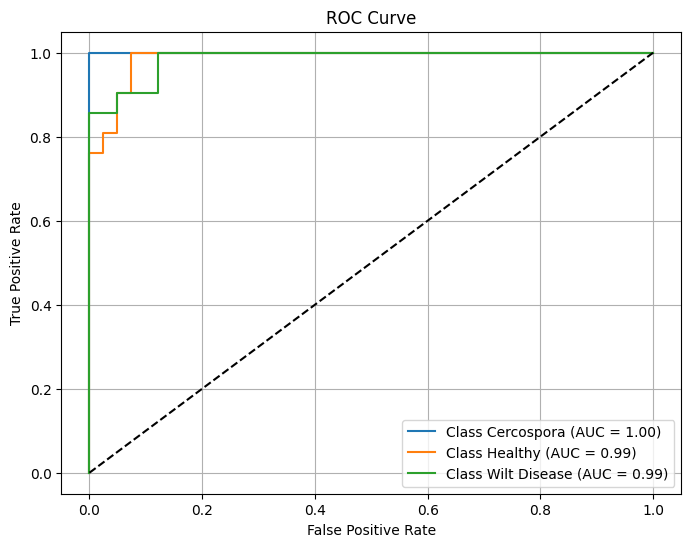

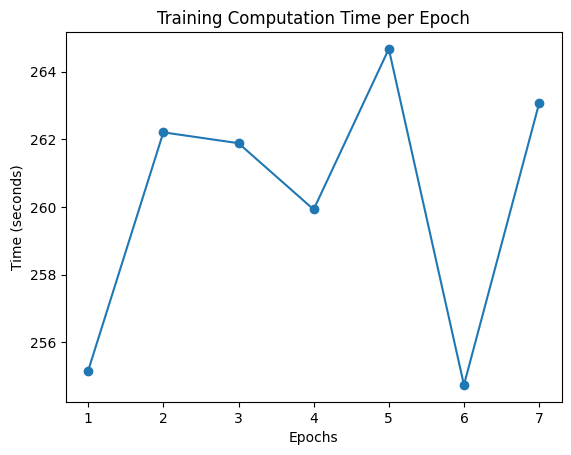

#### EfficientNetB0 Model Precision-Recall Curve values

In [10]:
# Precision-Recall Curve (for each class)
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(np.array(all_test_labels) == i, np.array(all_test_probs)[:, i])
    print('precision=',precision,'recall=',recall)

precision= [0.32258065 0.32786885 0.33333333 0.33898305 0.34482759 0.35087719
 0.35714286 0.36363636 0.37037037 0.37735849 0.38461538 0.39215686
 0.4        0.40816327 0.41666667 0.42553191 0.43478261 0.44444444
 0.45454545 0.46511628 0.47619048 0.48780488 0.5        0.51282051
 0.52631579 0.54054054 0.55555556 0.57142857 0.58823529 0.60606061
 0.625      0.64516129 0.66666667 0.68965517 0.71428571 0.74074074
 0.76923077 0.8        0.83333333 0.86956522 0.90909091 0.95238095
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ] recall= [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   0.95 0.9  0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35
 0.3  0.25 0.  ]
precision= [0.33870968 0.3442623  0.35    

<Figure size 800x600 with 0 Axes>

#### EfficientNetB0 Model Auc-Roc values

In [11]:
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(np.array(all_test_labels) == i, np.array(all_test_probs)[:, i])
    roc_auc = auc(fpr, tpr)
    print('fpr=',fpr,'tpr=',tpr)

fpr= [0. 0. 0. 1.] tpr= [0.   0.25 1.   1.  ]
fpr= [0.         0.         0.         0.02439024 0.02439024 0.04878049
 0.04878049 0.07317073 0.07317073 1.        ] tpr= [0.         0.04761905 0.76190476 0.76190476 0.80952381 0.80952381
 0.9047619  0.9047619  1.         1.        ]
fpr= [0.         0.         0.         0.04878049 0.04878049 0.12195122
 0.12195122 1.        ] tpr= [0.         0.04761905 0.85714286 0.85714286 0.9047619  0.9047619
 1.         1.        ]
